In [ ]:
import math  
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import sys

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# --- Action/Observation Classes ---

class observation_space:
    def __init__(self, n):
        self.shape = (n,)

class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)
    

    
# --- Environment Classe ---
class Environment:
    def __init__(
        self,
        features,                   
        window=24,
        lags=6,
        min_performance=0.2,       
        buffer_steps=50,           
        performance_check=False,
        random_start=False,
        hyperparameter_tuning=False
    ):
        self.df = features.copy()
        self.window = window
        self.lags = lags
        self.min_performance = min_performance
        self.buffer_steps = buffer_steps
        self.performance_check = performance_check
        self.random_start = random_start

        self.feature_names = [col for col in self.df.columns if col != 'spike_30']
        self.n_features = len(self.feature_names)

        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self.data_ = self.df.copy()
        self.hyperparameter_tuning = hyperparameter_tuning
        
        # TP: 97.0, FN: -83.5, TN: 14.25, FP: -14.0 model 150
        #TP: 97.0, FN: -83.5, TN: 14.25, FP: -14.0 model 170
        # Initialize adaptive reward parameters.
        self.reward_spike_tp = 93.5    # Reward for true positive (correct spike prediction)
        self.reward_spike_fn = -80.5   # Penalty for false negative (missed spike)
        self.reward_non_spike_tn = 14  # Reward for true negative (correct non-spike)
        self.reward_non_spike_fp = -13.75 # Penalty for false positive (incorrect spike prediction)

    def _get_state(self):
        return self.data_.iloc[self.bar - self.lags : self.bar][self.feature_names]

    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        # If random_start is True, choose a random starting index ensuring room for at least buffer_steps.
        if self.random_start:
            max_start = len(self.data_) - self.buffer_steps if len(self.data_) > self.buffer_steps else self.lags
            self.start_index = random.randint(self.lags, max_start)
        else:
            self.start_index = self.lags
        self.bar = self.start_index
        state = self._get_state()
        return state.values

    def step(self, action):
        expected = self.data_['spike_30'].iloc[self.bar]
        correct = (action == expected)

        if expected == 1:
            if action == 1:
                reward = self.reward_spike_tp
            else:
                reward = self.reward_spike_fn
        else:
            if action == 0:
                reward = self.reward_non_spike_tn
            else:
                reward = self.reward_non_spike_fp

        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.start_index)

        alpha = 0.2  # Smoothing factor for performance update.
        self.performance = (1 - alpha) * self.performance + alpha * (1 if correct else 0)


        if self.bar >= len(self.data_):
            done = True
        elif self.performance_check:
            if (self.bar - self.start_index) < self.buffer_steps:
                done = False
            else:
                done = self.performance < self.min_performance
        else:
            done = False

        next_state = self._get_state()
        info = {"correct": correct, "expected": expected, "action": action}
        return next_state.values, reward, done, info

    def adjust_reward_parameters(self, spike_recall, accuracy, tp_precision, tn_precision, fn_count, fp_count, 
                               target_recall=0.5, target_tp_precision=0.5, target_tn_precision=0.8, 
                               target_accuracy=0.7, delta=0.5):
        """
        Adjust reward parameters only if overall accuracy is below target_accuracy.
        Adjustments are made individually based on:
        - spike_recall: If too low, increase reward for TP and make FN penalty harsher.
        - tp_precision: If too low, further boost the spike TP reward.
        - tn_precision: If too low, boost the reward for correct non-spike predictions.
        - FN fraction: FN fraction = 1 - spike_recall; if > 0.3, further penalize FN.
        - FP fraction: FP fraction = 1 - tn_precision; if > 0.3, further penalize FP.
        Penalty rewards (for FN and FP) are ensured to remain non-positive.
        """
        if self.hyperparameter_tuning:
            if accuracy >= target_accuracy and spike_recall >= target_recall:
                print("Overall accuracy is good. No reward adjustments needed.")
                print(f"Current rewards: TP: {self.reward_spike_tp}, FN: {self.reward_spike_fn}, TN: {self.reward_non_spike_tn}, FP: {self.reward_non_spike_fp}")
            else:
                # Adjust based on spike recall.
                if spike_recall < target_recall:
                    self.reward_spike_tp += delta
                    self.reward_spike_fn -= delta
                    print(f"Low spike recall ({spike_recall:.2f}): Increasing TP reward to {self.reward_spike_tp} "
                        f"and decreasing FN penalty to {self.reward_spike_fn}")
                
                # Adjust based on TP precision.
                if tp_precision < target_tp_precision:
                    self.reward_spike_tp += delta
                    print(f"Low TP precision ({tp_precision:.2f}): Increasing TP reward to {self.reward_spike_tp}")
                
                # Adjust based on TN precision.
                if tn_precision < target_tn_precision:
                    self.reward_non_spike_tn += delta*.5
                    print(f"Low TN precision ({tn_precision:.2f}): Increasing TN reward to {self.reward_non_spike_tn}")
                
                # Adjust based on FN fraction among positives.
                fn_fraction = 1 - spike_recall  # FN / (TP+FN)
                if fn_fraction > 0.3:
                    self.reward_spike_fn -= delta
                    print(f"High FN fraction ({fn_fraction:.2f}): Further decreasing FN reward to {self.reward_spike_fn}")
                
                # Adjust based on FP fraction among negatives.
                fp_fraction = 1 - tn_precision  # FP / (TN+FP)
                if fp_fraction > 0.3:
                    self.reward_non_spike_fp -= delta*0.5
                    print(f"High FP fraction ({fp_fraction:.2f}): Further decreasing FP penalty to {self.reward_non_spike_fp}")
            
            # Ensure that penalty rewards remain non-positive.
            self.reward_non_spike_fp = min(self.reward_non_spike_fp, 0)
            self.reward_spike_fn = min(self.reward_spike_fn, 0)
            print(f"Adjusted rewards: TP: {self.reward_spike_tp}, FN: {self.reward_spike_fn}, TN: {self.reward_non_spike_tn}, FP: {self.reward_non_spike_fp}")

# --- Agent Class ---

class FQLAgent:
    def __init__(self, hidden_units, learning_rate, learn_env, valid_env, debug=False):
        self.learn_env = learn_env
        self.valid_env = valid_env
        
        self.lags = self.learn_env.lags
        self.n_features = self.learn_env.n_features

        self.epsilon = 0.1
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        self.learning_rate = learning_rate
        self.gamma = 0.95
        self.batch_size = 256
        self.alpha = 0.1

        self.threshold = 0.5
        self.debug = debug

        self.memory = deque(maxlen=20000)

        self.max_treward = 0
        self.trewards = []
        self.averages = []
        self.performances = []
        self.aperformances = []
        self.vperformances = []

        self.model = self._build_model(hidden_units, learning_rate)
        self.target_model = self._build_model(hidden_units, learning_rate)



    def _build_model(self, hu, lr):
        model = Sequential()
        # First LSTM layer
        model.add(LSTM(64, return_sequences=True, input_shape=(self.lags, self.n_features)))
        model.add(Dropout(0.2)) 
        # Second LSTM layer to capture deeper temporal dependencies.
        model.add(LSTM(hu))
        model.add(Dropout(0.2))
        # Increase network capacity with additional Dense layers.
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        # Final Dense layer with linear activation for Q-value predictions.
        model.add(Dense(2, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
        return model





    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            # 1) Predict the current Q-values from the online model.
            q_current = self.model.predict(state, verbose=0)

            # 2) Compute the Q-learning target for the next state.
            if not done:
                q_next = self.target_model.predict(next_state, verbose=0)
                td_target = reward + self.gamma * np.max(q_next[0])
            else:
                td_target = reward

            # 3) Incorporate alpha (the smoothing coefficient).
            old_value = q_current[0][action]
            new_value = old_value + self.alpha * (td_target - old_value)
            q_current[0][action] = new_value

            # 4) Update the model by fitting to the updated Q-value.
            self.model.fit(state, q_current, epochs=1, verbose=0)

        # 5) Decay epsilon for the epsilon-greedy policy.
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags, self.valid_env.n_features])

        y_val_true = []
        y_val_pred = []

        for t in range(len(self.valid_env.data_)):
            q_values = self.model.predict(state, verbose=0)
            if self.debug:
                print("Q-values:", q_values)
            action = np.argmax(q_values[0])
            next_state, reward, done, info = self.valid_env.step(action)

            y_val_true.append(info['expected'])
            y_val_pred.append(action)

            state = np.reshape(next_state, [1, self.valid_env.lags, self.valid_env.n_features])
            if done or self.valid_env.bar >= len(self.valid_env.data_):
                break

        cm_val = confusion_matrix(y_val_true, y_val_pred)
        tqdm.write(f"Validation Confusion Matrix at Episode {e}:")
        tqdm.write(str(cm_val))

        if cm_val.shape == (2, 2):
            tn = cm_val[0, 0]
            fp = cm_val[0, 1]
            fn = cm_val[1, 0]
            tp = cm_val[1, 1]

            spike_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            tp_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            tn_precision = tn / (tn + fp) if (tn + fp) > 0 else 0
            acc = accuracy_score(y_val_true, y_val_pred)

            tqdm.write(f"Accuracy: {acc:.2f}")
            tqdm.write(f"Spike Recall (TP/(TP+FN)): {spike_recall:.2f}")
            tqdm.write(f"TP Precision (TP/(TP+FP)): {tp_precision:.2f}")
            tqdm.write(f"TN Precision (TN/(TN+FP)): {tn_precision:.2f}")
            tqdm.write(f"FN Count: {fn}")
            tqdm.write(f"FP Count: {fp}")

            # Call the reward adjustment function.
            self.learn_env.adjust_reward_parameters(
                spike_recall, acc, tp_precision, tn_precision, fn, fp,
                target_recall=0.5, target_tp_precision=0.5, target_tn_precision=0.8,
                target_accuracy=0.7, delta=0.5
            )


            fn_fraction = 1 - spike_recall  # FN fraction among positives.
            fp_fraction = 1 - tn_precision    # FP fraction among negatives.
            # Adjust threshold if either error fraction exceeds 0.3.
            """if fn_fraction > 0.3 or fp_fraction > 0.3:
                # Here, we increase the threshold if FP dominates; otherwise, decrease it.
                if fp_fraction > fn_fraction:
                    self.threshold = min(self.threshold + 0.05, 0.7)
                else:
                    self.threshold = max(self.threshold - 0.05, 0.3)
                tqdm.write(f"Adjusting threshold to {self.threshold:.2f} based on error fractions (FN: {fn_fraction:.2f}, FP: {fp_fraction:.2f})")"
                """
        else:
            tqdm.write("Confusion matrix does not have both classes.")




    def learn(self, episodes, target_update_interval=5):
        for e in tqdm(range(1, episodes + 1), desc="Training episodes", file=sys.stdout):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags, self.learn_env.n_features])
            
            # Lists to store true labels and predictions for this episode.
            train_y_true = []
            train_y_pred = []
            
            for t in range(len(self.learn_env.data_)):
                action = self.act(state)
                next_state, reward, done, info = self.learn_env.step(action)
                next_state = np.reshape(next_state, [1, self.learn_env.lags, self.learn_env.n_features])
                self.memory.append((state, action, reward, next_state, done))
                
                # Accumulate true labels and predictions.
                train_y_true.append(info['expected'])
                train_y_pred.append(action)
                
                state = next_state

                if done or self.learn_env.bar >= len(self.learn_env.data_):
                    treward = t + 1
                    self.trewards.append(treward)
                    av = np.mean(self.trewards[-25:]) if len(self.trewards) >= 25 else np.mean(self.trewards)
                    perf = self.learn_env.performance
                    self.performances.append(perf)
                    ap = np.mean(self.performances[-25:]) if len(self.performances) >= 25 else np.mean(self.performances)
                    self.averages.append(av)
                    self.aperformances.append(ap)
                    self.max_treward = max(self.max_treward, treward)

                    tqdm.write(
                        f"Ep: {e}/{episodes} | treward: {self.learn_env.treward} | perf: {perf:.3f} "
                        f"| av: {av:.1f} | max: {self.max_treward}"
                    )
                    if e % 10 == 0:
                        model_filename = f"full_model_episode_{e}.h5"
                        self.model.save(model_filename)
                        tqdm.write(f"Model saved to '{model_filename}'")
                    break

            cm_train = confusion_matrix(train_y_true, train_y_pred)
            tqdm.write(f"Training Confusion Matrix at Episode {e}:")
            tqdm.write(str(cm_train))

            if e % 2 == 0:
                self.validate(e, episodes)

            if len(self.memory) > self.batch_size:
                self.replay()
            if e % target_update_interval == 0:
                self.target_model.set_weights(self.model.get_weights())
                tqdm.write("Target network updated.")

# --- Data Preprocessing ---

import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

def standardize_data(df: pd.DataFrame, gaussian: list = [], uniform: list = [], skewed: list = []):
    gaussian_transformer = StandardScaler()
    uniform_transformer = MinMaxScaler()
    skewed_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('gaussian', gaussian_transformer, gaussian),
        ('uniform', uniform_transformer, uniform),
        ('skewed', skewed_transformer, skewed)
    ])

    transformed_data = preprocessor.fit_transform(df)

    transformed_df = pd.DataFrame(
        transformed_data,
        columns=gaussian + uniform + skewed
    )

    return transformed_df

# --- Main Script ---

if __name__ == '__main__':
    file_path = "../data/ml_features_subset_rl.csv"
    full_df = pd.read_csv(file_path, index_col="date")
    gaussian = []
    uniform = ['is_weekend', 'is_holiday', 'hour', 'month']
    skewed = ['hdd', 'cdd', 'past_spikes_30', 'past_spikes_45', 'past_spikes_60', 'load_capacity_ratio', 'past_da_load_error', 'past_da_price_error',
              'wind_speed']
    standardized_data = standardize_data(full_df, gaussian, uniform, skewed)

    standardized_data['spike_30'] = full_df['spike_30'].values
    standardized_data.head()

    full_df = standardized_data.copy()

    total_len = len(full_df)
    train_end_idx = int(total_len * 0.65)
    valid_end_idx = int(total_len * 0.80)

    train_df = full_df.iloc[:train_end_idx].copy()
    valid_df = full_df.iloc[train_end_idx:valid_end_idx].copy()
    test_df  = full_df.iloc[valid_end_idx:].copy()

    window = 24
    lags = 60

    learn_env = Environment(
        features=train_df,
        window=window,
        lags=lags,
        min_performance=0.7,
        buffer_steps=3000,
        performance_check=True,
        random_start=True,
        hyperparameter_tuning=True
    )

    valid_env = Environment(
        features=valid_df,
        window=window,
        lags=lags,
        min_performance=0.7,
        buffer_steps=500,
        performance_check=True,
        random_start=True,
        hyperparameter_tuning=True
    )

    test_env = Environment(
        features=test_df,
        window=window,
        lags=lags,
        min_performance=0.4,
        buffer_steps=1000,
        performance_check=False,
        random_start=False
    )





    hidden_units = 128
    learning_rate = 0.001

    agent = FQLAgent(
        hidden_units=hidden_units,
        learning_rate=learning_rate,
        learn_env=learn_env,
        valid_env=valid_env,
        debug=False
    )


    agent.model.load_weights("full_model_episode_120.h5")
    agent.target_model.set_weights(agent.model.get_weights())



    episodes = 170
    agent.learn(episodes)

    tqdm.write("\n--- Testing on Test Environment (Full Pass) ---")
    state = test_env.reset()
    state = np.reshape(state, [1, test_env.lags, test_env.n_features])
    done = False
    total_reward = 0
    y_true = []
    y_pred = []

    while not done:
        q_values = agent.model.predict(state, verbose=0)
        action = np.argmax(q_values[0])
        next_state, reward, done, info = test_env.step(action)
        next_state = np.reshape(next_state, [1, test_env.lags, test_env.n_features])
        state = next_state

        total_reward += reward
        y_true.append(info['expected'])
        y_pred.append(action)

    tqdm.write(f"Test run finished, total reward: {total_reward}")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tqdm.write("\nConfusion Matrix:")
    tqdm.write(str(cm))

    report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
    tqdm.write("\nClassification Report:")
    tqdm.write(report)


In [ ]:
test_env = Environment(
    features=test_df,
    window=window,
    lags=lags,
    min_performance=0.4,
    buffer_steps=1000,
    performance_check=False,
    random_start=False
)





hidden_units = 128
learning_rate = 0.001

agent = FQLAgent(
    hidden_units=hidden_units,
    learning_rate=learning_rate,
    learn_env=learn_env,
    valid_env=valid_env,
    debug=False
)


#to load last trained model weights in case of interruption
agent.model.load_weights("full_model_episode_150.h5")
agent.target_model.set_weights(agent.model.get_weights())




tqdm.write("\n--- Testing on Test Environment (Full Pass) ---")
state = test_env.reset()
state = np.reshape(state, [1, test_env.lags, test_env.n_features])
done = False
total_reward = 0
y_true = []
y_pred = []

while not done:
    q_values = agent.model.predict(state, verbose=0)
    action = np.argmax(q_values[0])
    next_state, reward, done, info = test_env.step(action)
    next_state = np.reshape(next_state, [1, test_env.lags, test_env.n_features])
    state = next_state

    total_reward += reward
    y_true.append(info['expected'])
    y_pred.append(action)

tqdm.write(f"Test run finished, total reward: {total_reward}")

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
tqdm.write("\nConfusion Matrix:")
tqdm.write(str(cm))

report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
tqdm.write("\nClassification Report:")
tqdm.write(report)

c:\Users\hirja\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Testing on Test Environment (Full Pass) ---
Test run finished, total reward: 112178.25

Confusion Matrix:
[[8311 1203]
 [ 383  462]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.87      0.91      9514
     Class 1       0.28      0.55      0.37       845

    accuracy                           0.85     10359
   macro avg       0.62      0.71      0.64     10359
weighted avg       0.90      0.85      0.87     10359



In [6]:
# Convert y_pred to a DataFrame and add a timestamp column for saving
n_rows = len(y_pred)
timestamps = pd.date_range(end='2023-12-31 23:00:00', periods=n_rows, freq='H')
y_pred_df = pd.DataFrame(y_pred, columns=['predicted_spike'])
y_pred_df.insert(0, 'timestamp', timestamps)
y_pred_df.to_csv('final_test_ioan_predicted_spikes.csv', index=False)

C:\Users\hirja\AppData\Local\Temp\ipykernel_16268\3796689052.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(end='2023-12-31 23:00:00', periods=n_rows, freq='H')


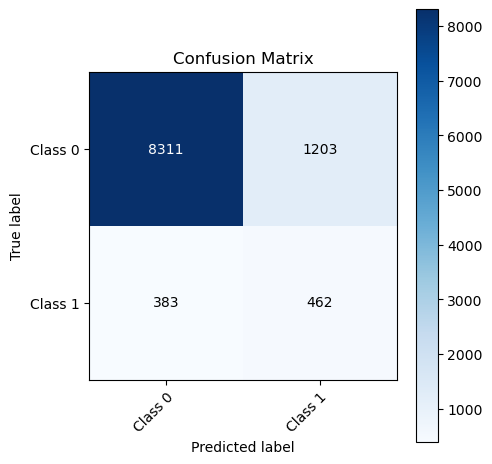

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix from y_true and y_pred.
cm = confusion_matrix(y_true, y_pred)

# Define class names (adjust if your classes differ).
classes = ['Class 0', 'Class 1']

# Create a figure and axis.
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set axis labels and title.
tick_marks = np.arange(len(classes))
ax.set(xticks=tick_marks, yticks=tick_marks,
       xticklabels=classes, yticklabels=classes,
       ylabel='True label', xlabel='Predicted label',
       title='Confusion Matrix')

# Rotate the tick labels if needed.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()
